# Sample Sankay
- sankay plot to display bks set of cbc metagenomics samples
- goal: use sankay to display fates over time of tagged colonies (that were sequenced) and have number of samples (or preferably numbers of circles) of those colonies at each time point
- https://github.com/davidsjoberg/ggsankey - it should be possible to do numbers, but don't know if i can add in the additional feature of sample to colony? 

In [8]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(purrr)
library(stringr)
library(reshape2) 
library(ggsankey)

In [9]:
samplelist<-read.table('../inputs/genohublist_sctld2024.txt', header = FALSE)
colony <- read_csv("/Users/brookesienkiewicz/Documents/sctld/SCTLD_samples/Sample_Data/CBC_ColonyData.csv", show_col_types = FALSE)
sctld_samples <- read.csv("/Users/brookesienkiewicz/Documents/sctld/SCTLD_samples/Sample_Data/CBC_samples.csv")

New names:
• `` -> `...1`


In [10]:
# add colony ids to all dfs
add_colonyid <- function(df) {
    # get transect # 
    df$transect_id <- paste0('T',df$TransectNum)
    # make colony id 
    df$colony_id <- paste(df$transect_id, df$NewTagNum, df$Species,
                                 sep = "_")
    return(df)
}

# apply 
sctld_samples<-add_colonyid(sctld_samples)
colony <- add_colonyid(colony)

In [11]:
colnames(sctld_samples)

[1] "Month_year"                   "Country"                     
 [3] "Location"                     "CollectionDate"              
 [5] "Transect"                     "TransectNum"                 
 [7] "OldTagNum"                    "NewTagNum"                   
 [9] "Species"                      "Time_sampled"                
[11] "Time_processed"               "Sample_type"                 
[13] "SampleNum"                    "Health_status"               
[15] "Sampling_notes"               "Tubelabel_species"           
[17] "Sample_physical_location"     "Extraction_physical_location"
[19] "Date_sequenced"               "Notes"                       
[21] "transect_id"                  "colony_id"

In [12]:
#filter sample data to match sequence list 
sctld_samples<-sctld_samples %>%
    filter(Sample_type == 'Core_EtOH') %>%
    filter(Tubelabel_species %in% samplelist$V1) %>%

    # and only keep disease tissue for visualizing for now 
    filter(Health_status != "Diseased_Margin")
nrow(sctld_samples)

# filter colony data to match sequence list 
colony <- colony %>%
    filter(colony_id %in% sctld_samples$colony_id)

length(unique(colony$colony_id))
# 113 unique colonies - 220 total samples, only 197 if excl disease margin

[1] 197

[1] 113

In [13]:
# convert condition columns in colony data to month year format 

## change colnames into dates 
# list columns with dates
tf <- grepl('Condition', colnames(colony))
date_col <- colnames(colony)[tf]

# get rid of 'condition' to have col names just contain the date
new_col<-gsub('_Condition', '',date_col)

# convert to mmyydd date format before final date conversion 
formatted_dates <- as.Date(paste0(new_col, "01"), format = "%m%Y%d")

# Format the dates as "Nov 2023", etc.
formatted_labels <- format(formatted_dates, "%b %Y")

# Replace the column names in clb_colony with the formatted labels
colnames(colony)[tf] <- formatted_labels 

#this is the new list of condiiton columns to use going forward
sample_dates <- c('Jun 2019','May 2022','Dec 2022')

In [14]:
# filter colony data for these dates
colony <- colony %>%
    select(colony_id, Species, any_of(sample_dates))

In [15]:
# convert collection date in sample data to month year format 

sctld_samples$dates <- as.Date(sctld_samples$CollectionDate, format = "%m/%d/%y")

# convert to mmyyyy and make separate column for written month year 
sctld_samples$Month_year <- format(sctld_samples$dates, "%b %Y")

# make all 2019 same month for simplicity 
sctld_samples[sctld_samples$Month_year=='Oct 2019',"Month_year"]='Jun 2019'

# arrange in chronological order 
sctld_samples$Month_year<-factor(sctld_samples$Month_year, levels = sample_dates) 

In [16]:
# use make long on filtered colony first then match the sample data to x1

In [17]:
head(colony)
head(sctld_samples)

colony_id,Species,Jun 2019,May 2022,Dec 2022
<chr>,<chr>,<chr>,<chr>,<chr>
T1_2_PAST,PAST,Healthy,Healthy,Healthy
T1_4_PSTR,PSTR,Healthy,Diseased,Dead
T1_6_PSTR,PSTR,Healthy,Healthy,Diseased
T1_7_MCAV,MCAV,Healthy,Healthy,Healthy
T1_8_MCAV,MCAV,Healthy,Diseased,Diseased
T1_12_PSTR,PSTR,Healthy,Healthy,Healthy


,Month_year,Country,Location,CollectionDate,Transect,TransectNum,OldTagNum,NewTagNum,Species,Time_sampled,⋯,Health_status,Sampling_notes,Tubelabel_species,Sample_physical_location,Extraction_physical_location,Date_sequenced,Notes,transect_id,colony_id,dates
,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>
1,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,22,OANN,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_136_OANN,Depleted_UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B3,,,T1,T1_22_OANN,2022-12-02
2,May 2022,BEL,CBC,5/21/22,CBC30N,1,22,22,OANN,,⋯,Healthy,newly added May 2022,052022_BEL_CBC_T1_41_OANN,Depleted_UML_NARWHAL_R1_B3,UML_NARWHAL_R2_B3,,,T1,T1_22_OANN,2022-05-21
3,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,12,PSTR,,⋯,Healthy,,122022_BEL_CBC_T1_122_PSTR,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_12_PSTR,2022-12-02
4,Dec 2022,BEL,CBC,12/4/22,CBC30N,1,,6,PSTR,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_132_PSTR,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_6_PSTR,2022-12-04
5,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,20,PAST,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_139_PAST,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_20_PAST,2022-12-02
6,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,8,MCAV,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_144_MCAV,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_8_MCAV,2022-12-02


In [18]:
# if something dies, change dec condition to dead instead of not_visited
colony <-colony %>%
    mutate(`Dec 2022` = ifelse(
        (`May 2022` == 'Dead') & (`Dec 2022` == "Not_Visited"), 
        'Dead',
        `Dec 2022`))

In [19]:
sankeydf <- data.frame()
for(id in unique(colony$colony_id)){
    # print(id)
    #create dfs for individual colonies 
    df <- colony %>%
        filter(colony_id == id)
    # print(df)

    # pivot longer
    sankdf <- df %>% 
     make_long(all_of(sample_dates)) %>%
     mutate(colony_id = id) 
    # print("sankdf")
    # print(sankdf)

    # combine into 1 df
   sankeydf <- sankeydf %>%
     bind_rows(sankdf)
    # print("sankeydf")
    # print(sankeydf)
}
# print commands are for troubleshooting

In [20]:
testid = 'T1_2_PAST' 
tail(strsplit(testid, "_")[[1]], 1)

[1] "PAST"

In [21]:
# add species labels and sample statuses for each colony id 

# filter sctld_samples to match sankeydf format 
sampledf <- sctld_samples %>% 
    select(colony_id, Month_year, Health_status) %>%
    rename(x = Month_year,
          sample_condition = Health_status)

# merge
sankey <- sankeydf %>%
    left_join(sampledf,
         # match sample conditions to 'x' (first time point in the set) 
             by = c('colony_id','x')) %>%
        # add species grouping based on colony id 
    rowwise() %>%    
    mutate(species = tail(strsplit(colony_id, "_")[[1]], 1))

head(sankey,10)

x,node,next_x,next_node,colony_id,sample_condition,species
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
Jun 2019,Healthy,May 2022,Healthy,T1_2_PAST,Healthy,PAST
May 2022,Healthy,Dec 2022,Healthy,T1_2_PAST,Healthy,PAST
Dec 2022,Healthy,NA,NA,T1_2_PAST,Healthy,PAST
Jun 2019,Healthy,May 2022,Diseased,T1_4_PSTR,Healthy,PSTR
May 2022,Diseased,Dec 2022,Dead,T1_4_PSTR,Diseased_Tissue,PSTR
Dec 2022,Dead,NA,NA,T1_4_PSTR,NA,PSTR
Jun 2019,Healthy,May 2022,Healthy,T1_6_PSTR,Healthy,PSTR
May 2022,Healthy,Dec 2022,Diseased,T1_6_PSTR,Healthy,PSTR
Dec 2022,Diseased,NA,NA,T1_6_PSTR,Diseased_Tissue,PSTR


In [22]:
unique(sankey$node)

[1] "Healthy"     "Diseased"    "Dead"        NA            "DC"         
[6] "Not_Visited"

In [23]:
# change NA in earlier dates to not yet tagged (will need to apply this to the overall df if it works)
sankey<-sankey %>%
     # for early dates (in x), change na (in node) to Not_yet_tagged 
    mutate(node = if_else(
        (is.na(node) & (x == 'May 2022' | x == 'Jun 2019')), 
        'Not_yet_tagged', node)) %>%

    # and do the same for next_node when may 2022 in 'next_x'
    mutate(next_node = if_else(
        is.na(next_node) & (next_x == 'May 2022'), 
        'Not_yet_tagged', next_node))

In [24]:
write_csv(x = sankey, file = 'sankeydf.csv')

In [25]:
sank_colors = c('Dead'='tomato3',
                'Healthy'='palegreen3',
                 'DC' = 'thistle2',
                 'Diseased' = 'salmon1',
                 'Diseased_Other' = 'coral3',
                 'Not_Visited' = 'wheat2',
                 'Not_yet_tagged' = 'gray78')

In [26]:
options(repr.plot.width=12, repr.plot.height=10)

In [27]:
# test with 1 species first 
mcav <-sankey %>%
    filter(species == 'MCAV')
head(mcav)

x,node,next_x,next_node,colony_id,sample_condition,species
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
Jun 2019,Healthy,May 2022,Healthy,T1_7_MCAV,Healthy,MCAV
May 2022,Healthy,Dec 2022,Healthy,T1_7_MCAV,Healthy,MCAV
Dec 2022,Healthy,NA,NA,T1_7_MCAV,Healthy,MCAV
Jun 2019,Healthy,May 2022,Diseased,T1_8_MCAV,Healthy,MCAV
May 2022,Diseased,Dec 2022,Diseased,T1_8_MCAV,Diseased_Tissue,MCAV
Dec 2022,Diseased,NA,NA,T1_8_MCAV,Diseased_Tissue,MCAV


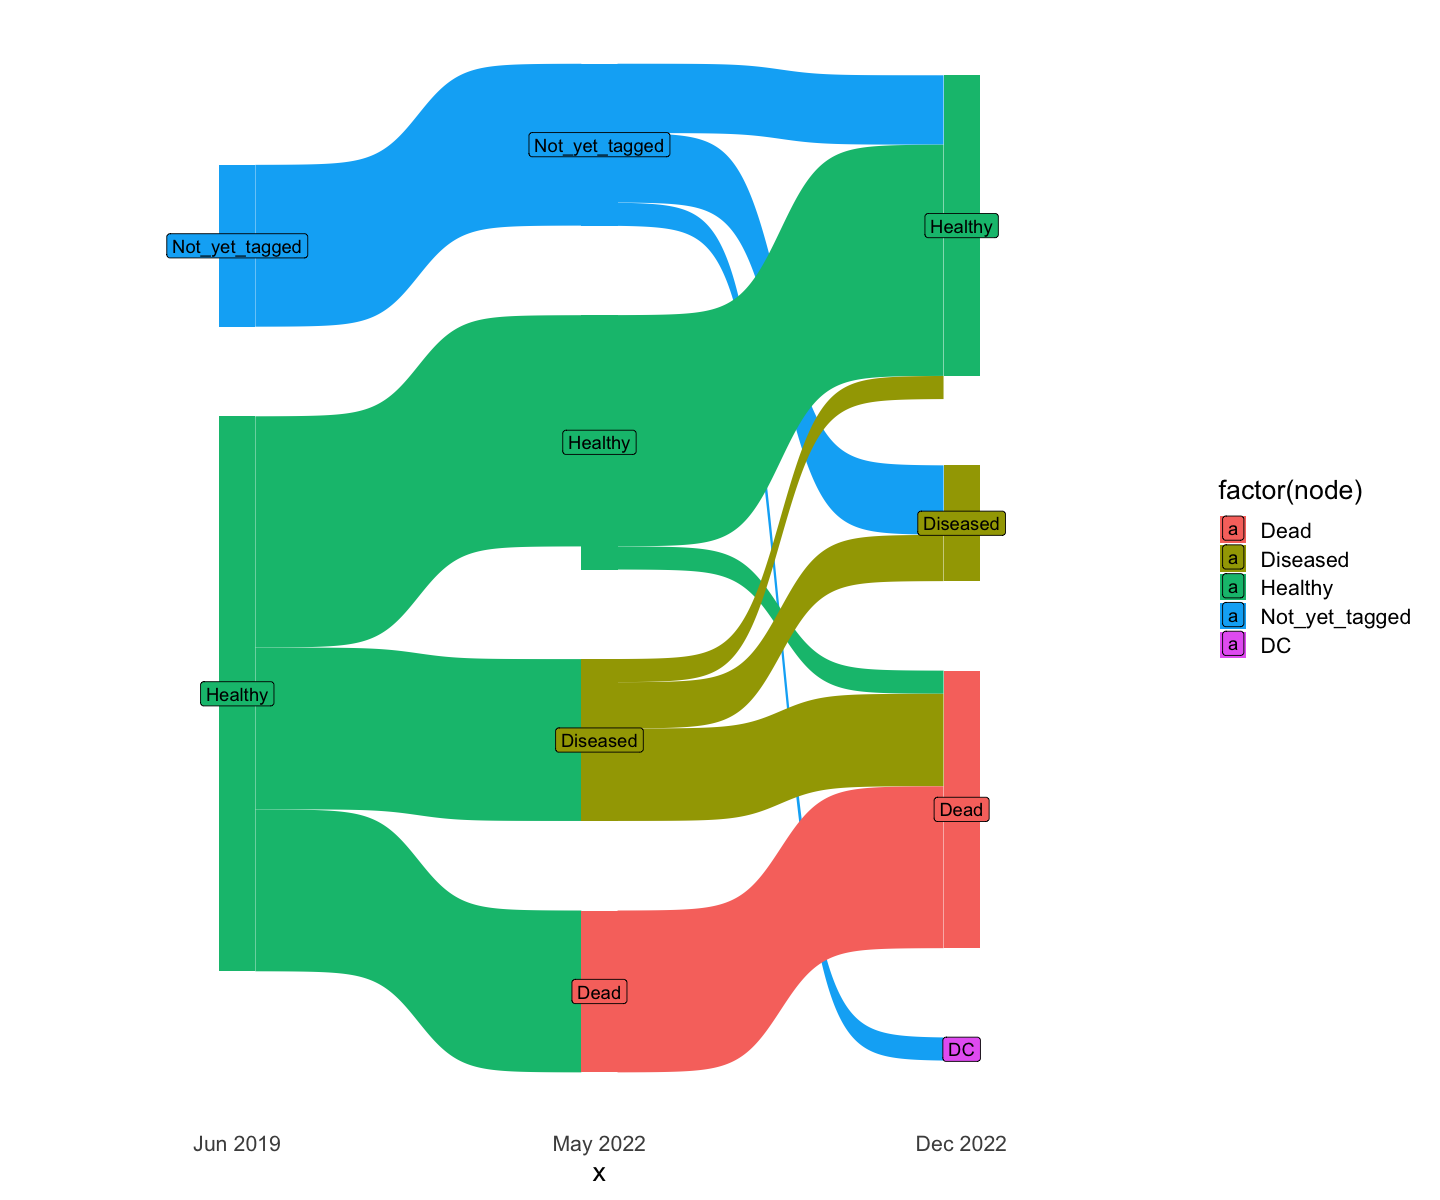

In [28]:
# plot simple first 
ggplot(mcav, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label() +
  theme_sankey(base_size = 16)

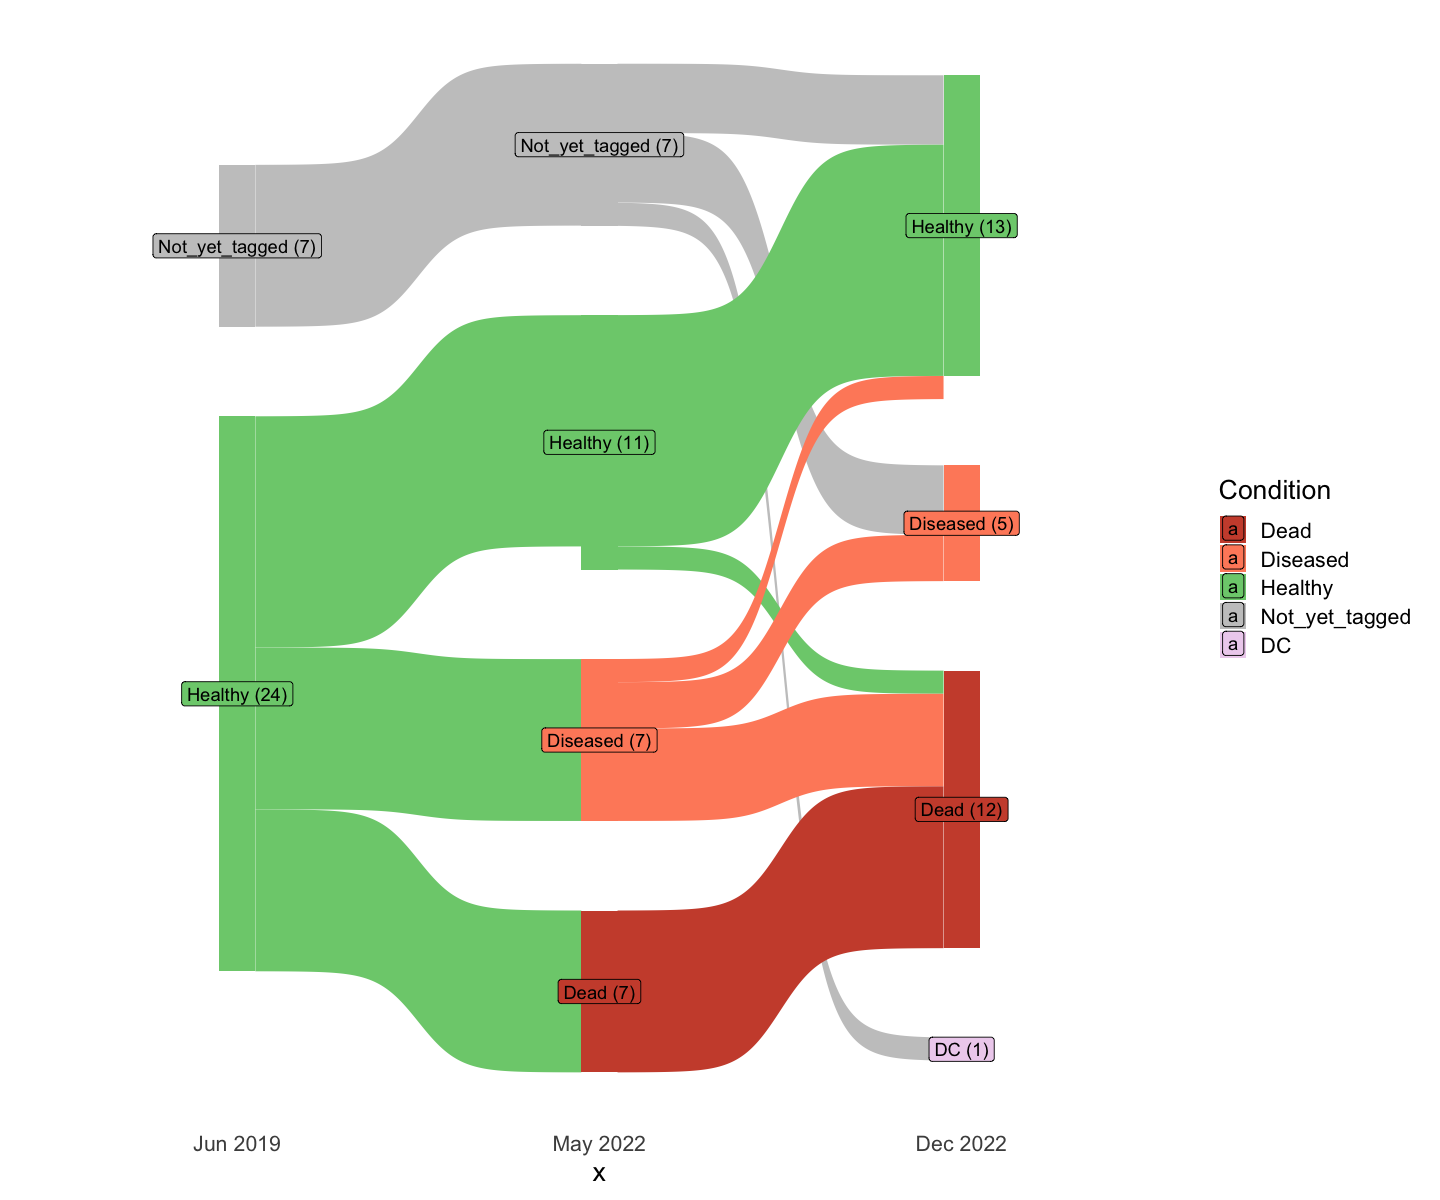

In [30]:
# add colony counts and custom colors 
ggplot(mcav, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label(aes(
      # colony counts 
       label = paste0(node, " (", after_stat(freq), ")")
  )
  ) +
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = c(sank_colors))

# investigate DC - should we just call it healthy or diseased for our purposes?

In [31]:
head(mcav)

x,node,next_x,next_node,colony_id,sample_condition,species
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
Jun 2019,Healthy,May 2022,Healthy,T1_7_MCAV,Healthy,MCAV
May 2022,Healthy,Dec 2022,Healthy,T1_7_MCAV,Healthy,MCAV
Dec 2022,Healthy,NA,NA,T1_7_MCAV,Healthy,MCAV
Jun 2019,Healthy,May 2022,Diseased,T1_8_MCAV,Healthy,MCAV
May 2022,Diseased,Dec 2022,Diseased,T1_8_MCAV,Diseased_Tissue,MCAV
Dec 2022,Diseased,NA,NA,T1_8_MCAV,Diseased_Tissue,MCAV


In [35]:
# summarize counts by colony condition (node) + sample_condition
counts <- mcav %>%
  count(x, node, sample_condition, name = "n_samples")

# join back to sankey df
mcav_counts <- mcav %>%
  left_join(counts, by = c("x", "node", "sample_condition"))
head(mcav_counts)

x,node,next_x,next_node,colony_id,sample_condition,species,n_samples
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>
Jun 2019,Healthy,May 2022,Healthy,T1_7_MCAV,Healthy,MCAV,24
May 2022,Healthy,Dec 2022,Healthy,T1_7_MCAV,Healthy,MCAV,10
Dec 2022,Healthy,NA,NA,T1_7_MCAV,Healthy,MCAV,13
Jun 2019,Healthy,May 2022,Diseased,T1_8_MCAV,Healthy,MCAV,24
May 2022,Diseased,Dec 2022,Diseased,T1_8_MCAV,Diseased_Tissue,MCAV,6
Dec 2022,Diseased,NA,NA,T1_8_MCAV,Diseased_Tissue,MCAV,5


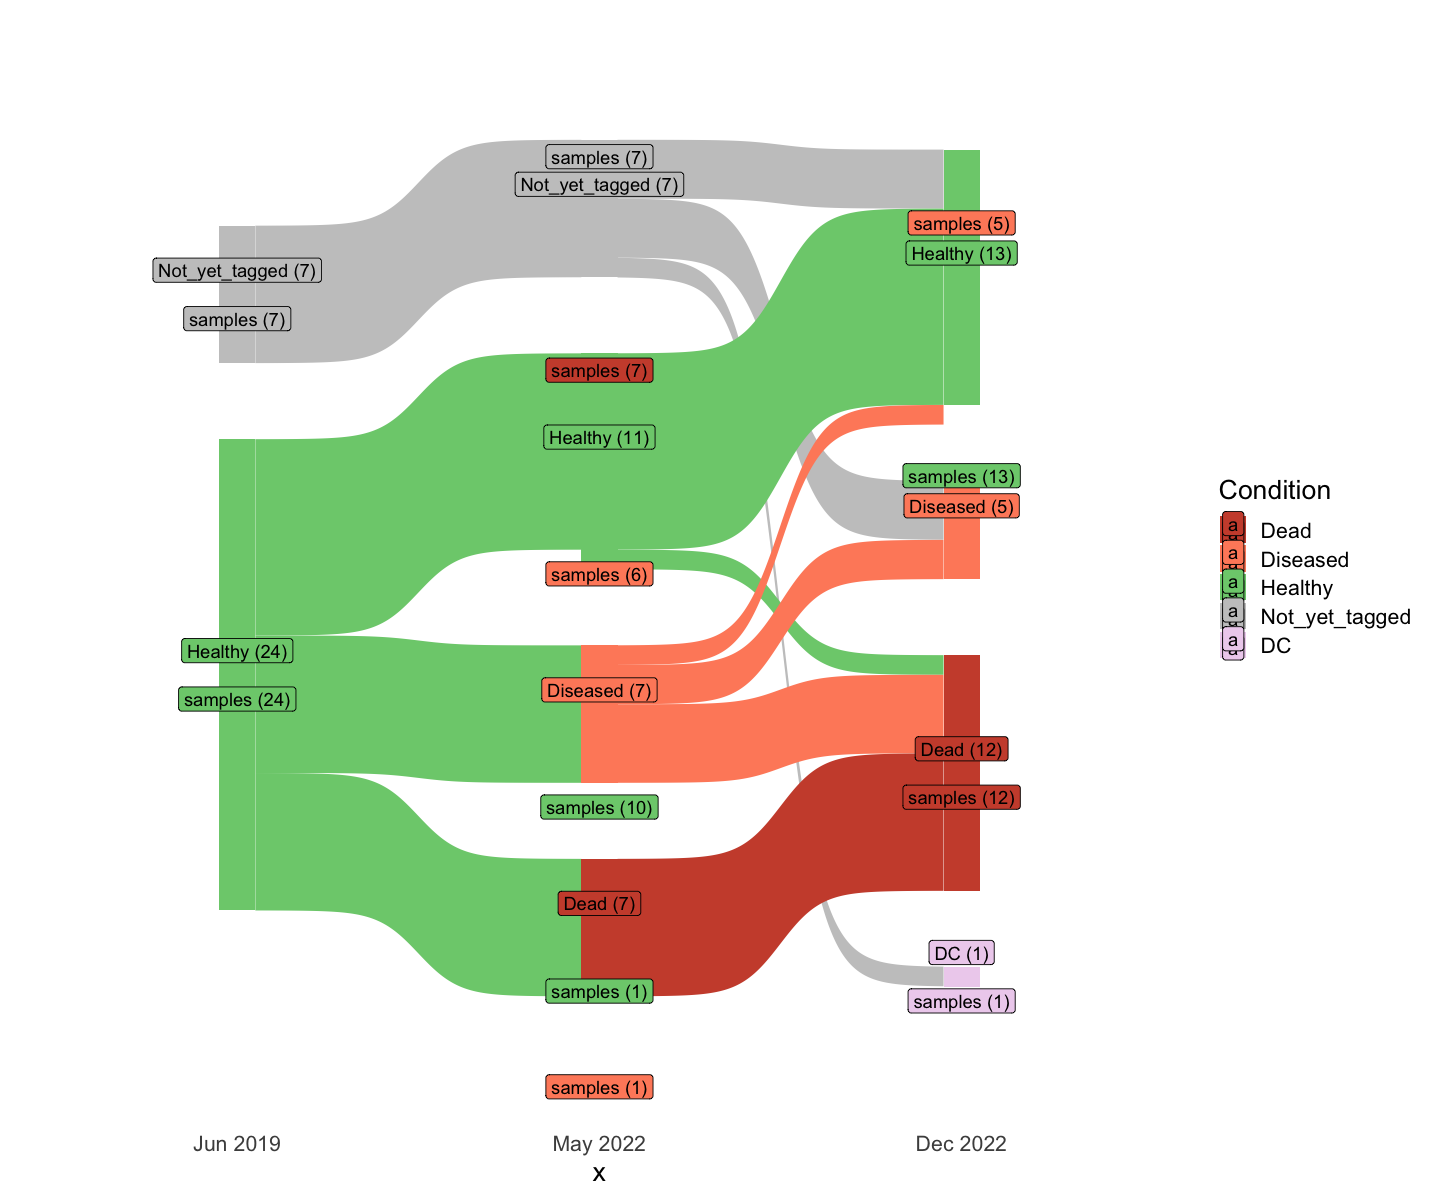

In [43]:
# add sample counts
ggplot(mcav_counts, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label(aes(
      # colony counts 
      label = paste0(node, " (", after_stat(freq), ")")),
                    # stagger labels
                    vjust = -0.5) +

  geom_sankey_label(aes(
      # sample counts 
      label = paste0("samples", " (",n_samples,")")),
                    # stagger labels 
                    vjust = 1.5) +
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = c(sank_colors))


In [45]:
# investigate the not-yet-tagged samples
mcav_counts %>%
    filter(node=='Not_yet_tagged')
mcav_counts %>%
    filter(node=='Dead')
# there should be no samples here 

x,node,next_x,next_node,colony_id,sample_condition,species,n_samples
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>
Jun 2019,Not_yet_tagged,May 2022,Not_yet_tagged,T3_67_MCAV,NA,MCAV,7
May 2022,Not_yet_tagged,Dec 2022,Diseased,T3_67_MCAV,NA,MCAV,7
Jun 2019,Not_yet_tagged,May 2022,Not_yet_tagged,T3_71_MCAV,NA,MCAV,7
May 2022,Not_yet_tagged,Dec 2022,DC,T3_71_MCAV,NA,MCAV,7
Jun 2019,Not_yet_tagged,May 2022,Not_yet_tagged,T4_28_MCAV,NA,MCAV,7
May 2022,Not_yet_tagged,Dec 2022,Healthy,T4_28_MCAV,NA,MCAV,7
Jun 2019,Not_yet_tagged,May 2022,Not_yet_tagged,T4_30_MCAV,NA,MCAV,7
May 2022,Not_yet_tagged,Dec 2022,Healthy,T4_30_MCAV,NA,MCAV,7
Jun 2019,Not_yet_tagged,May 2022,Not_yet_tagged,T4_76_MCAV,NA,MCAV,7


x,node,next_x,next_node,colony_id,sample_condition,species,n_samples
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>
Dec 2022,Dead,NA,NA,T1_14_MCAV,NA,MCAV,12
Dec 2022,Dead,NA,NA,T1_15_MCAV,NA,MCAV,12
May 2022,Dead,Dec 2022,Dead,T1_329_MCAV,NA,MCAV,7
Dec 2022,Dead,NA,NA,T1_329_MCAV,NA,MCAV,12
May 2022,Dead,Dec 2022,Dead,T1_333_MCAV,NA,MCAV,7
Dec 2022,Dead,NA,NA,T1_333_MCAV,NA,MCAV,12
May 2022,Dead,Dec 2022,Dead,T1_342_MCAV,NA,MCAV,7
Dec 2022,Dead,NA,NA,T1_342_MCAV,NA,MCAV,12
May 2022,Dead,Dec 2022,Dead,T1_355_MCAV,NA,MCAV,7


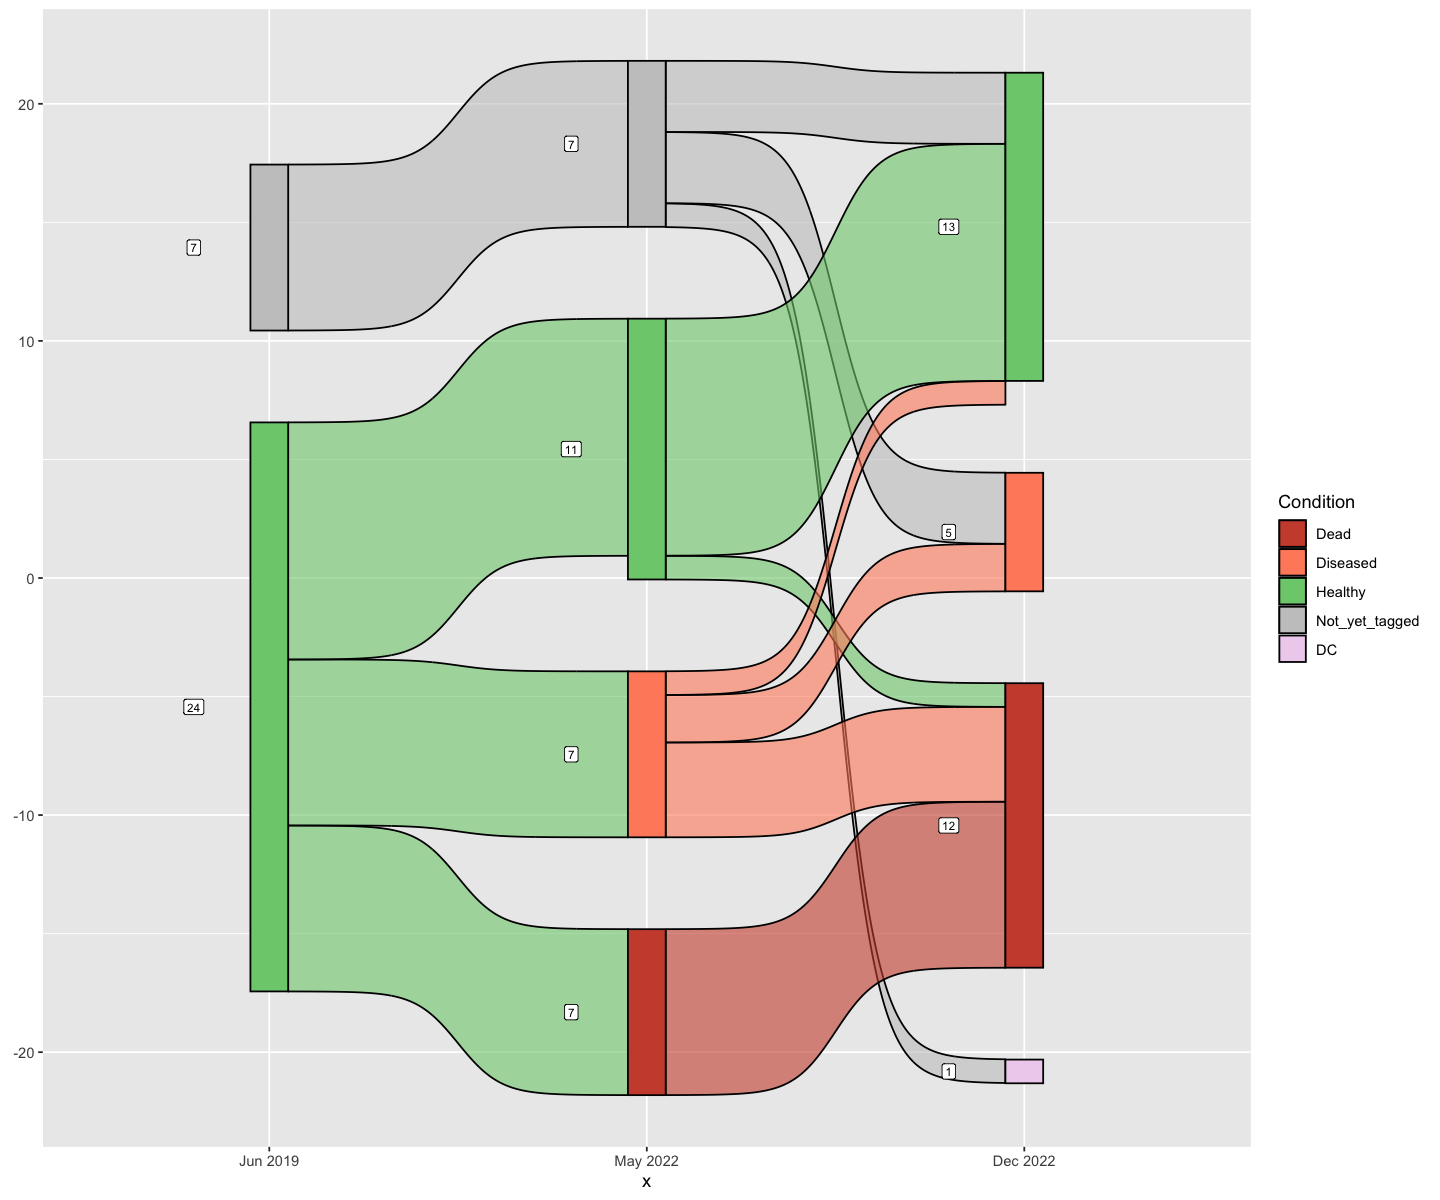

In [363]:
pl <- ggplot(mcav, aes(x = x, 
                next_x = next_x, 
                node = node, 
                next_node = next_node,
               fill = factor(node))) +
   geom_sankey(flow.alpha = 0.6, node.color = 'black', flow.color = 'black') +
   geom_sankey_label(
     aes(
       x = as.numeric(x) - 0.2,
       label = after_stat(freq)),
     size = 7 / .pt, color = "black", fill = "white") +  
   scale_fill_manual("Condition", values = c(sank_colors))
pl